In [1]:
!conda install -y cuda -c nvidia/label/cuda-11.4.0

Solving environment: done

# All requested packages already installed.



In [2]:
!conda install -y cuquantum -c conda-forge 

Solving environment: done

# All requested packages already installed.



In [3]:
!pip install cuquantum

In [4]:
!pip install  PennyLane==0.27.0 PennyLane-Lightning==0.27.0 Pennylane-lightning-gpu==0.27.0

In [5]:
import pennylane as qml
import pennylane.numpy as np

In [6]:
!pip install medmnist

In [7]:
def get_data():
    # pip install medmnist
    import medmnist
    from medmnist import INFO
    data_flag = 'pneumoniamnist'

    info = INFO[data_flag]
    DataClass = getattr(medmnist, info['python_class'])
    pil_dataset_train = DataClass(split='train', download=True)
    pil_dataset_test = DataClass(split='test', download=True)
    return pil_dataset_train, pil_dataset_test

data_train, data_test = get_data()
train_images = data_train.imgs/255.0
train_labels = data_train.labels

Using downloaded and verified file: /home/jovyan/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /home/jovyan/.medmnist/pneumoniamnist.npz


In [8]:
!pip install matplotlib

In [9]:
!pip install idx2numpy

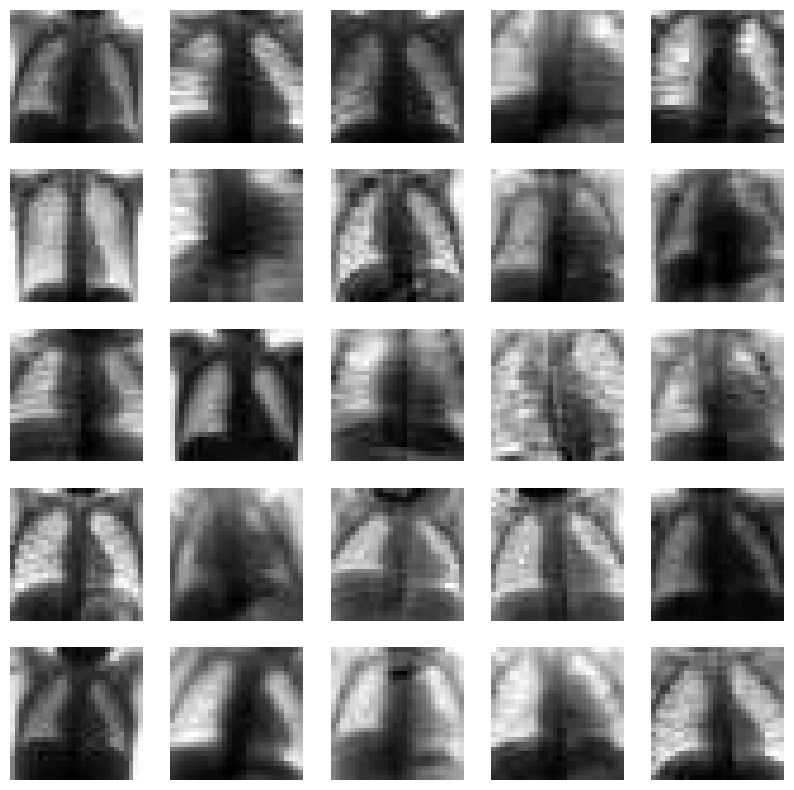

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.axis("off")

In [11]:
device = "cpu"
# device = "cuda"
import time,os,copy
import idx2numpy 
import numpy as np 
from tqdm import tqdm

seed = 42
np.random.seed(seed)

In [12]:
# splitting the full dataset of 5 classes into test and train images to ensure the testing does not happen on images from train data.
from os import mkdir
from os.path import exists
split = np.array_split(train_images,[int(len(train_images)*0.7)])
train_sequences = split[0]
test_sequences = split[1]
print(len(split[0]),len(split[1]))
split = np.array_split(train_labels,[int(len(train_labels)*0.7)])
train_labels = split[0]
test_labels = split[1]
print(len(split[0]),len(split[1]))
datalength = 5000
# we restrict the training to first 5000 images of 21000
n_steps = 10
train_sequences = np.tile(train_sequences[:, None], (1, n_steps, 1, 1))#[:datalength]
test_sequences = np.tile(test_sequences[:, None], (1, n_steps, 1, 1))
# train_labels = train_labels[:datalength]


create = True
if exists("./saved_data_PneumoniaMNIST"):
    create=False

if create:
    mkdir("./saved_data_PneumoniaMNIST")
    np.savez_compressed("./saved_data_PneumoniaMNIST/test_labels.npz",test_labels)
    np.savez_compressed(f"./saved_data_PneumoniaMNIST/test_seqs_{seed}.npz",test_sequences)
    np.savez_compressed("./saved_data_PneumoniaMNIST/train_labels.npz",train_labels)
    np.savez_compressed(f"./saved_data_PneumoniaMNIST/train_seqs_{seed}.npz",train_sequences)

print(len(test_labels),len(test_sequences),len(train_labels),len(train_sequences))

3295 1413
3295 1413
1413 1413 3295 3295


In [13]:
def salt_pepper(test_sequences,test_labels,prob,salt=0,pepper=1):
  sampled_images = test_sequences
  sampled_labels = test_labels
  for j in range(len(test_labels)):
    for i in range(np.shape(sampled_images[j])[0]):
      for y in range(28):
        for x in range(28):
          r = np.random.random() 
          if r < prob:
            sampled_images[j][i][y][x] = salt
          elif r > 1-prob:
            sampled_images[j][i][y][x] = pepper
  return sampled_images,sampled_labels

In [14]:
if create:
    for i in range(1,10,1):
        d , l =salt_pepper(np.load(f"./saved_data_PneumoniaMNIST/test_seqs_{seed}.npz")['arr_0'],np.load(f"./saved_data_PneumoniaMNIST/test_labels.npz")['arr_0'],i/100.0)
        np.savez_compressed(f"./saved_data_PneumoniaMNIST/snp_{i/100.0}_{seed}.npz",d)
    for i in range(1,6,1):
        d , l =salt_pepper(np.load(f"./saved_data_PneumoniaMNIST/test_seqs_{seed}.npz")['arr_0'],np.load(f"./saved_data_PneumoniaMNIST/test_labels.npz")['arr_0'],i/10.0)
        np.savez_compressed(f"./saved_data_PneumoniaMNIST/snp_{i/10.0}_{seed}.npz",d)

noise probability = 0.48
1noise probability = 0.18
2noise probability = 0.18
3noise probability = 0.18
4noise probability = 0.18
5noise probability = 0.18
6noise probability = 0.18
7noise probability = 0.18
8noise probability = 0.18
9

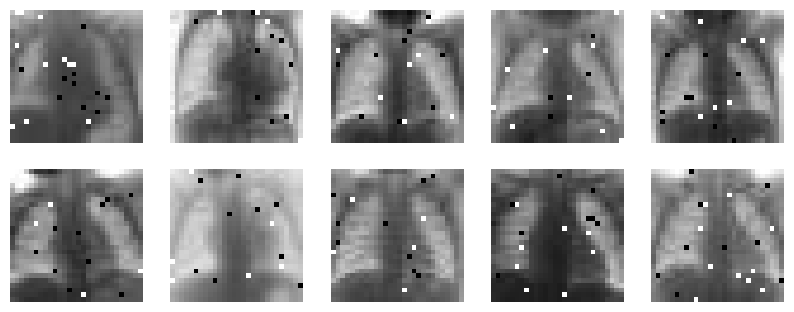

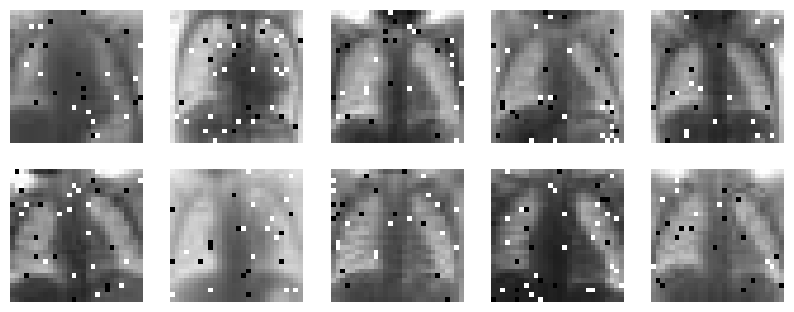

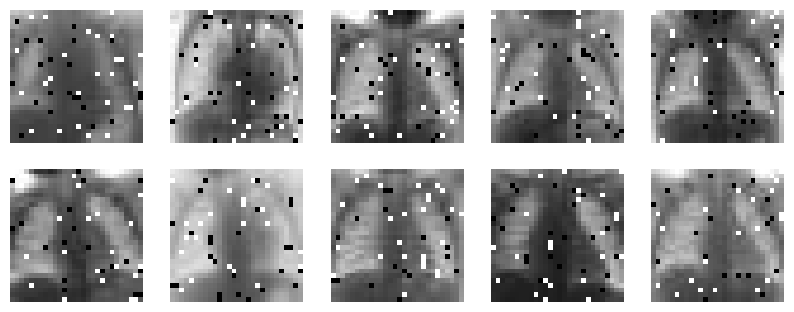

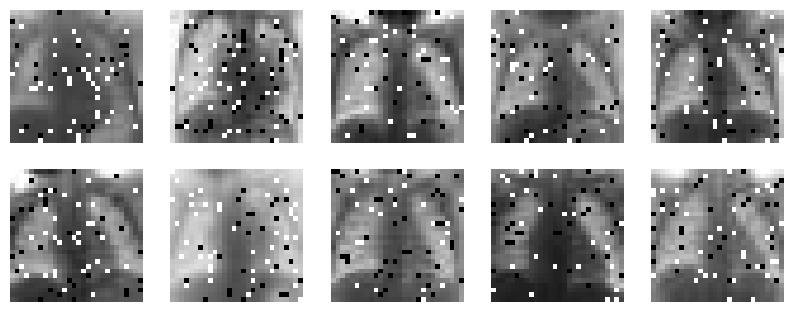

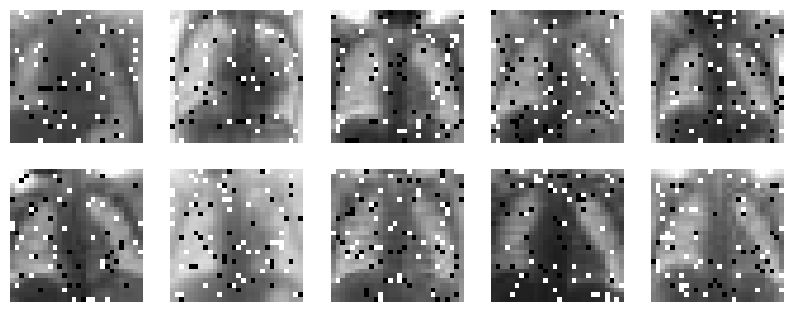

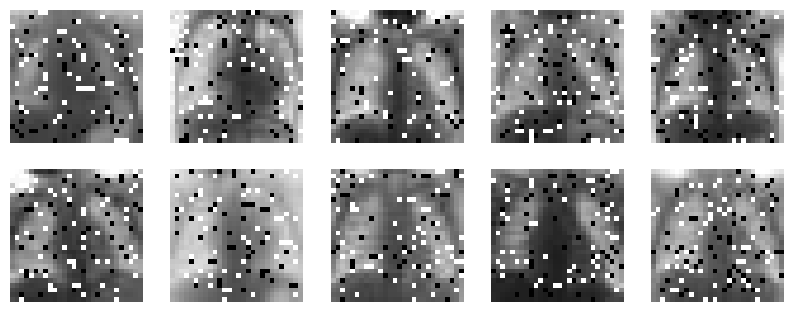

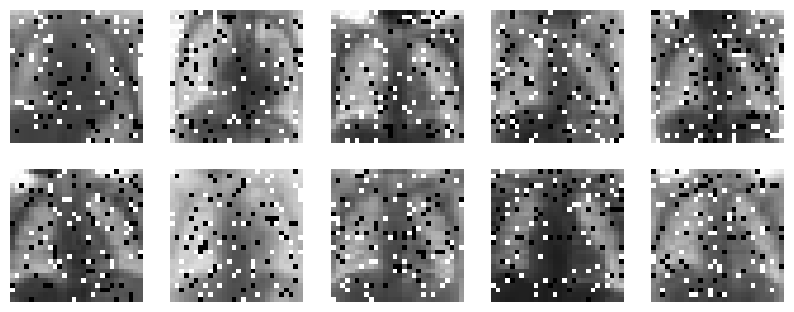

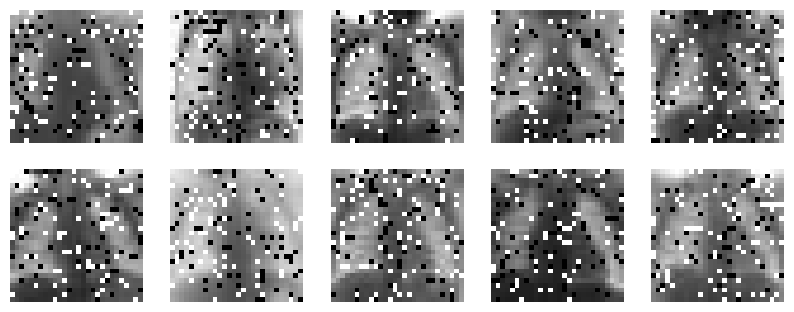

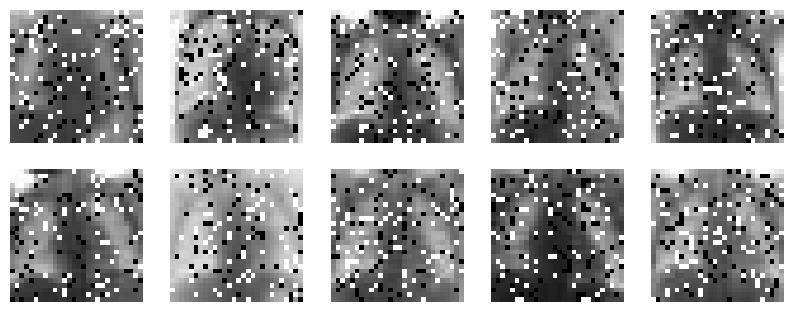

In [15]:
for ii in range(1,10,1):
    print(f"noise probability = {2*i/100.}")
    d = np.load(f"./saved_data_PneumoniaMNIST/snp_{ii/100.0}_{seed}.npz")['arr_0']
    l = np.load(f"./saved_data_PneumoniaMNIST/test_labels.npz")['arr_0']
    plt.figure(figsize=(10, 10))
    for i in range(10):
        plt.subplot(5, 5, i + 1)
        plt.imshow(d[i+2][0], cmap=plt.cm.binary)
        plt.axis("off")
        #plt.title(class_names[l[i+2]])
    #plt.show()
    print(ii,end='')
    plt.savefig(f"./saved_data_PneumoniaMNIST/snp_{str(ii/100.0)}.png",dpi=500,transparent=False)
    plt.savefig(f"./saved_data_PneumoniaMNIST/snp_{str(ii/100.0)}.ps")

In [16]:
if create:
  for i in tqdm([i for i in range(1,10)]+[i/10 for i in range(1,10)]):
    sampled_images = np.load(f"./saved_data_PneumoniaMNIST/test_seqs_{seed}.npz")['arr_0']
    sampled_labels = np.load("./saved_data_PneumoniaMNIST/test_labels.npz")['arr_0']
    sigma = (i*0.1)**0.5
    mean = 0
    for j in range(len(sampled_labels)):
      for _ in range(len(sampled_images[j])):
        row,col = sampled_images[j][_].shape
        # gauss = np.array(np.random.normal(mean,sigma,size=(28,28))).reshape(row,col)
        gauss = np.array(np.random.randn(row*col)) #* var ** 0.5 + mean
        gauss = gauss*sigma + mean
        gauss = gauss.reshape(row,col)
        sampled_images[j][_] = sampled_images[j][_] + gauss
    np.savez_compressed(f"./saved_data_PneumoniaMNIST/gauss_{round(i/10., 2)}_{seed}.npz",sampled_images)

In [17]:
index_x=['x0','x1','x2','x3','x4']
index_y=['y0','y1','y2','y3','y4']
def encoder(image):
    for wire in (index_x+index_y):
        qml.Hadamard(wires=wire)
    for i in range(len(image)):
        y = bin(i)[2:]
        y = '0'*(5-len(y)) + y
        for j in range(len(image[0])):
            if image[i][j]>0.001:
                x = bin(j)[2:]
                x = '0'*(5-len(x)) + x
                qml.RY(image[i][j]/2,wires='gray')
                qml.MultiControlledX((index_x+index_y), 'gray', control_values=x+y)
                qml.RY(image[i][j]/2,wires='gray')

            

In [19]:
train_image=(np.load('./saved_data_PneumoniaMNIST/train_seqs_42.npz')['arr_0']) # train images
X=np.array([x[0] for x in train_image])
train_label=np.load('./saved_data_PneumoniaMNIST/train_labels.npz')['arr_0']


Y = np.array([y[0] for y in train_label]) # train lables
Y = Y * 2 - np.ones(len(Y)) # shift label from {0, 1} to {-1, 1}

In [20]:
def entangling_layer0(input_wires,output_wires,weights):
    
    weights_ = (weight for weight in weights)
    for i in input_wires:
        for j in output_wires:
            qml.CNOT(wires=[i,j])
            
            param = next(weights_)
            qml.RZ(param, wires=j)
            
            param = next(weights_)
            qml.RX(param, wires=j) 
            
            qml.CNOT(wires=[i,j])
            


In [21]:
def entangling_layer1(wires,weights):
    n=len(wires)
    weights_ = (weight for weight in weights)
    for i in range(1,n):
        j = 0
        r = []
        while j <= n-1:
            if j not in r:
                qml.CNOT([wires[j],wires[j+i]])
                r += [j+1]
            
                param = next(weights_)
                qml.RZ(param, wires=j)
            
                param = next(weights_)
                qml.RX(param, wires=j) 
            
                qml.CNOT([wires[j],wires[j+i]])
                j += 1
        for j in r:
            qml.CNOT([wires[j],wires[j+i]])
            
            param = next(weights_)
            qml.RZ(param, wires=j)
            
            param = next(weights_)
            qml.RX(param, wires=j) 
            
            qml.CNOT([wires[j],wires[j+i]])

In [22]:
# The training circuit
encoder_wires = ['x0','x1','x2','x3','x4','y0','y1','y2','y3','y4','gray','train']
dev = qml.device("default.qubit", wires=encoder_wires)
@qml.qnode(dev)
def circuit(weights, image):
    encoder(image)
    entangling_layer0(['x0','x1','x2','x3','x4','y0','y1','y2','y3','y4','gray'],['train'],weights)
    #entangling_layer1(['x0','x1','x2','x3','x4','y0','y1','y2','y3','y4','gray'],weights)
    return qml.expval(qml.PauliZ('train'))

In [23]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

In [24]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [25]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [26]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

In [27]:
import pennylane.numpy as np
np.random.seed(0)
weights_init = 0.01 * np.random.randn(22, requires_grad=True)
#weights_init = 0.01 * np.random.randn(110, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

In [28]:
from pennylane.optimize import NesterovMomentumOptimizer
opt = NesterovMomentumOptimizer(0.5)
batch_size = 2

In [ ]:
weights = weights_init
bias = bias_init
for it in range(2):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, 2306, (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]
    acc = accuracy(Y, predictions)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), acc
        )
    )

/opt/conda/lib/python3.10/site-packages/pennylane/ops/qubit/non_parametric_ops.py:2025: UserWarning: The control_wires keyword will be removed soon. Use wires = (control_wires, target_wire) instead. See the documentation for more information.
  warnings.warn(


In [ ]:
# test model with test dataset

test_X=(np.load(f"./saved_data_PneumoniaMNIST/test_seqs_42.npz")['arr_0']) # train images

test_label=np.load("./saved_data_PneumoniaMNIST/test_labels.npz")['arr_0']
test_Y = np.array([int(y) for y in test_label]) # train lables
test_Y = test_Y * 2 - np.ones(len(test_Y)) # shift label from {0, 1} to {-1, 1}

In [ ]:
test_predictions = [np.sign(variational_classifier(weights, bias, x)) for x in test_X]
test_acc = accuracy(test_Y, test_predictions)